# Welcome to the Thesis Notebook where measurements are pre-processed, cleaned, plotted and transformed
## Here, will be covered the measurements done using powerstat and the energy service + analyser service

In [12]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np
import csv


## Please modify root_path in order to switch experiments (idle or imaging)

In [156]:
# followed by folders each with their own .txt file
root_path = Path("data/before_intervention/battery_1min_600Hz(img)/energy_logs")
dir_list = os.listdir(root_path)

# Filter + sort by repetition number
sorted_dirs = sorted(
    [item for item in dir_list if re.match(r"energy_logs_(\d+)", item)],
    key=lambda name: int(re.search(r"energy_logs_(\d+)", name).group(1))
)

# Print sorted
print(sorted_dirs)

['energy_logs_00.csv', 'energy_logs_01.csv', 'energy_logs_02.csv', 'energy_logs_03.csv', 'energy_logs_04.csv', 'energy_logs_05.csv', 'energy_logs_06.csv', 'energy_logs_07.csv', 'energy_logs_08.csv', 'energy_logs_09.csv', 'energy_logs_10.csv', 'energy_logs_11.csv', 'energy_logs_12.csv', 'energy_logs_13.csv', 'energy_logs_14.csv', 'energy_logs_15.csv', 'energy_logs_16.csv', 'energy_logs_17.csv', 'energy_logs_18.csv', 'energy_logs_19.csv', 'energy_logs_20.csv', 'energy_logs_21.csv', 'energy_logs_22.csv', 'energy_logs_23.csv', 'energy_logs_24.csv', 'energy_logs_25.csv', 'energy_logs_26.csv', 'energy_logs_27.csv', 'energy_logs_28.csv', 'energy_logs_29.csv']


## Convert to dataframe

In [157]:
import glob

csv_dir = 'data/before_intervention/battery_1min_600Hz(img)/energy_logs'  # change if needed

# Pattern to match your energy_logs files
pattern = os.path.join(csv_dir, 'energy_logs_*.csv')

dataframes = {}

# Loop through each file and read into a DataFrame
for file_path in sorted(glob.glob(pattern)):
    df_name = os.path.splitext(os.path.basename(file_path))[0]
    dataframes[df_name] = pd.read_csv(file_path)

for name, df in dataframes.items():
    print(f"{name}: {len(df)} rows")


energy_logs_00: 9183 rows
energy_logs_01: 9288 rows
energy_logs_02: 9381 rows
energy_logs_03: 9458 rows
energy_logs_04: 9448 rows
energy_logs_05: 9382 rows
energy_logs_06: 9386 rows
energy_logs_07: 9480 rows
energy_logs_08: 9393 rows
energy_logs_09: 9468 rows
energy_logs_10: 9351 rows
energy_logs_11: 9378 rows
energy_logs_12: 9359 rows
energy_logs_13: 9406 rows
energy_logs_14: 9387 rows
energy_logs_15: 9459 rows
energy_logs_16: 9404 rows
energy_logs_17: 9393 rows
energy_logs_18: 9413 rows
energy_logs_19: 9458 rows
energy_logs_20: 9402 rows
energy_logs_21: 9409 rows
energy_logs_22: 9406 rows
energy_logs_23: 9451 rows
energy_logs_24: 9372 rows
energy_logs_25: 9369 rows
energy_logs_26: 9391 rows
energy_logs_27: 9457 rows
energy_logs_28: 9390 rows
energy_logs_29: 9480 rows


## PLOTS

### Here are plots for each individual run with their respective timestamps. Please check or change var of repetition for other runs

In [158]:
# import matplotlib.pyplot as plt

# # Loop through each DataFrame and generate a plot
# for name, df in dataframes.items():

#     # name_log = 'energy_logs_00'
#     df = dataframes[name]

#     # Extract relevant columns
#     time = df['timestamp']
#     current = df['current_amps']
#     voltage = df['supply_voltage']
#     power = df['power_watts']

#     # Plotting
#     plt.figure(figsize=(12, 6))
#     plt.plot(time, current, label='Current (A)')
#     plt.plot(time, voltage, label='Voltage (V)')
#     plt.plot(time, power, label='Power (W)')

#     plt.title(f"Energy Data Overview — {name}")
#     plt.xlabel("Timestamp")
#     plt.ylabel("Measurements")
#     plt.xticks(rotation=45)
#     plt.legend()
#     plt.tight_layout()
#     plt.show()
    

## Check power from before and after intervention

In [159]:
total_power = 0

for name, df in dataframes.items():
    power = df['power_watts']
    average_power = power.mean()
    print(f"Average Power for {name}: {average_power:.2f} W")
    total_power += average_power

overall_average = total_power / len(dataframes)
print(f"\nOverall average power across all runs: {overall_average:.2f} W")


Average Power for energy_logs_00: 7.64 W
Average Power for energy_logs_01: 7.78 W
Average Power for energy_logs_02: 7.51 W
Average Power for energy_logs_03: 7.49 W
Average Power for energy_logs_04: 7.49 W
Average Power for energy_logs_05: 7.50 W
Average Power for energy_logs_06: 7.55 W
Average Power for energy_logs_07: 7.45 W
Average Power for energy_logs_08: 7.50 W
Average Power for energy_logs_09: 7.50 W
Average Power for energy_logs_10: 7.50 W
Average Power for energy_logs_11: 7.51 W
Average Power for energy_logs_12: 7.57 W
Average Power for energy_logs_13: 7.53 W
Average Power for energy_logs_14: 7.48 W
Average Power for energy_logs_15: 7.49 W
Average Power for energy_logs_16: 7.48 W
Average Power for energy_logs_17: 7.54 W
Average Power for energy_logs_18: 7.48 W
Average Power for energy_logs_19: 7.42 W
Average Power for energy_logs_20: 7.47 W
Average Power for energy_logs_21: 7.48 W
Average Power for energy_logs_22: 7.51 W
Average Power for energy_logs_23: 7.47 W
Average Power fo

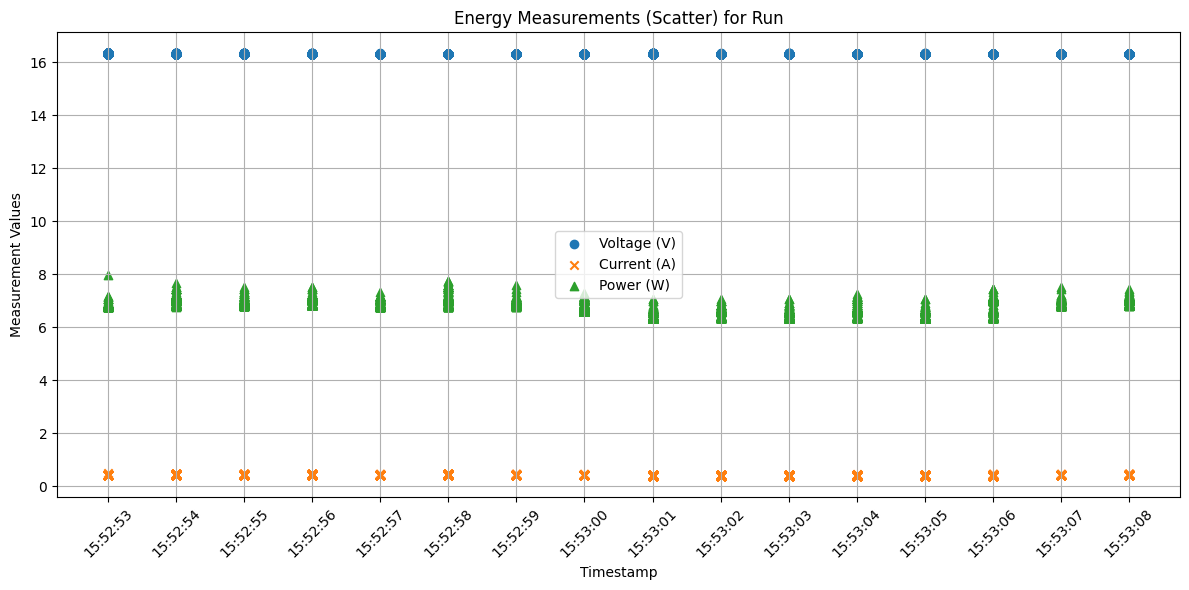

In [51]:
# Filter for run 11. Change for other run
run_df = dataframes['energy_logs_03']
# Plot
plt.figure(figsize=(12,6))

plt.scatter(run_df['timestamp'], run_df['supply_voltage'], label="Voltage (V)", marker='o')
plt.scatter(run_df['timestamp'], run_df['current_amps'], label="Current (A)", marker='x')
plt.scatter(run_df['timestamp'], run_df['power_watts'], label="Power (W)", marker='^')

plt.title("Energy Measurements (Scatter) for Run")
plt.xlabel("Timestamp")
plt.ylabel("Measurement Values")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Powerstat.csv

In [94]:
powerstat_path = 'data/conservative_intervention/battery_1min_600Hz(img)/powerstat.csv'

with open(powerstat_path, newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    for row in spamreader:
        print(', '.join(row))

Running, for, 2285.0, seconds, (4570, samples, at, 0.5, second, intervals).
Power, measurements, will, start, in, 0, seconds, time.

, , Time, , , , User, , Nice, , , Sys, , Idle, , , , IO, , Run, Ctxt/s, , IRQ/s, , Watts, , soc-th, cpu-th
11:28:26, , , 0.0, , , 0.0, , , 0.0, 100.0, , , 0.0, , , , 1, , , 1094, , , , 936, , , 0.00E, , 45.00, , 45.00
11:28:27, , , 0.0, , , 0.0, , , 0.5, , 99.5, , , 0.0, , , , 1, , , , 316, , , , 264, , , 0.00E, , 45.00, , 45.00
11:28:27, , , 1.5, , , 0.0, , , 4.5, , 90.9, , , 3.0, , , , 1, , , 1236, , , , 994, , , 0.00E, , 46.00, , 45.00
11:28:28, , , 9.3, , , 0.0, , , 9.3, , 65.3, , 16.1, , , , 2, , 29874, , 21546, , , 0.00E, , 46.00, , 45.00
11:28:28, , , 5.3, , , 0.0, , , 6.8, , 77.9, , 10.0, , , , 1, , 34002, , 25140, , , 0.00E, , 46.00, , 46.00
11:28:29, , , 3.2, , , 0.0, , , 4.2, , 92.1, , , 0.5, , , , 2, , 30912, , 24162, , , 0.00E, , 46.00, , 46.00
11:28:29, , , 8.5, , , 0.0, , , 4.8, , 85.6, , , 1.1, , , , 2, , 31382, , 24468, , , 0.00E, , 46.00

In [97]:
import pandas as pd
import re


# Read file lines
with open(powerstat_path, 'r') as f:
    lines = f.readlines()

data_rows = []
summary_rows = []

for line in lines:
    if re.match(r"^\d{2}:\d{2}:\d{2}", line):  # data line starting with timestamp
        data_rows.append(line.strip())
    elif re.match(r"^\s*(Average|GeoMean|StdDev|Minimum|Maximum)", line):
        summary_rows.append(line.strip())

# Create DataFrame for data rows
data_df = pd.DataFrame([re.split(r'\s+', row) for row in data_rows],
                       columns=["Time", "User", "Nice", "Sys", "Idle", "IO", "Run", "Ctxt/s", "IRQ/s", "Watts", "soc-th", "cpu-th"])

# Convert numeric columns to floats where possible
for col in data_df.columns[1:]:
    data_df[col] = pd.to_numeric(data_df[col], errors='coerce')

# Create DataFrame for summary rows
summary_df = pd.DataFrame([re.split(r'\s+', row, maxsplit=12) for row in summary_rows],
                          columns=["Label", "User", "Nice", "Sys", "Idle", "IO", "Run", "Ctxt/s", "IRQ/s", "Watts", "soc-th", "cpu-th"])

# Convert numeric columns to floats where appropriate
for col in summary_df.columns[1:]:
    summary_df[col] = pd.to_numeric(summary_df[col], errors='coerce')

# Dataframe with all the data
# data_df

# Dataframe with summary statistics
summary_df

,Label,User,Nice,Sys,Idle,IO,Run,Ctxt/s,IRQ/s,Watts,soc-th,cpu-th
0,Average,4.3,0.0,1.3,94.4,0.0,1.5,7600.9,5432.0,NaN,48.70,48.29
1,GeoMean,0.0,0.0,0.0,108.6,0.0,0.0,0.0,0.0,0.0,54.38,54.38
2,StdDev,8.7,0.0,2.3,10.7,0.3,0.9,14315.9,10162.7,NaN,1.45,1.20
3,Minimum,0.0,0.0,0.0,58.9,0.0,1.0,44.0,60.0,NaN,45.00,45.00
4,Maximum,30.3,0.0,23.7,100.0,16.1,8.0,38562.0,29236.0,NaN,53.00,52.00


## Plot Temperatures against Time: CPU-th, SOC-th

/var/folders/87/xbc8k_k17_n921xhcp1k1hnc0000gn/T/ipykernel_16730/3921839903.py:6: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled = data_df.resample('5T').mean()


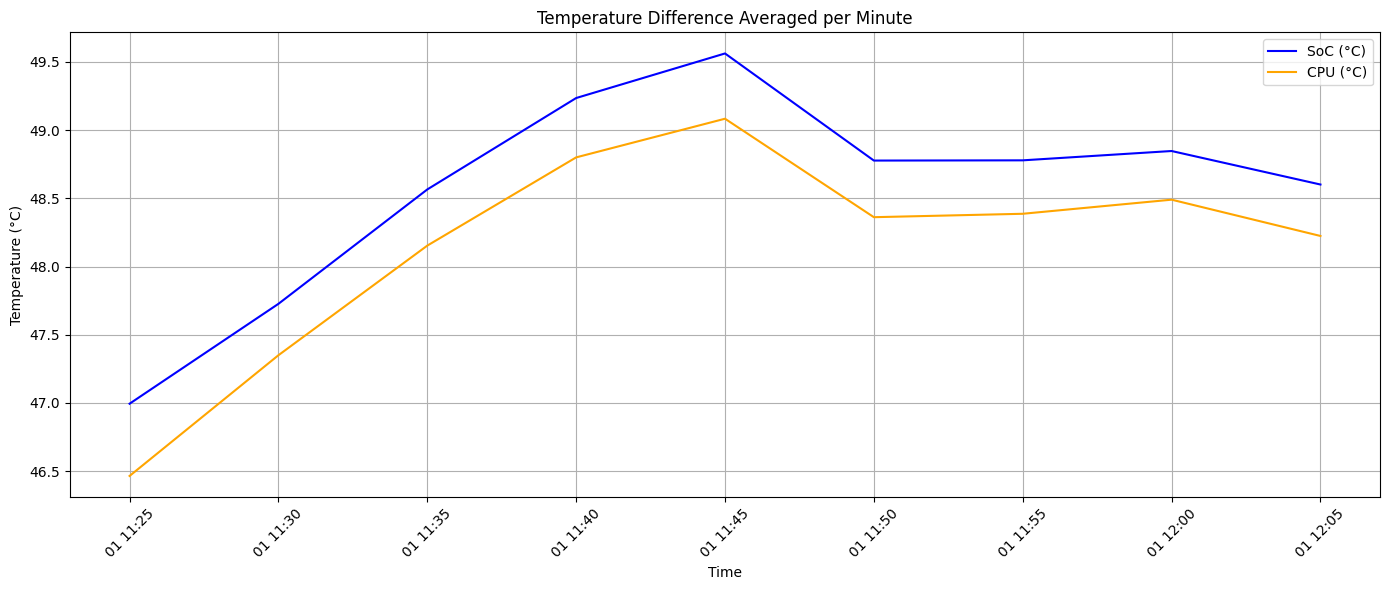

In [96]:
data_df['Time'] = pd.to_datetime(data_df['Time'], format='%H:%M:%S')

data_df.set_index('Time', inplace=True)

# Resample to 1-minute averages (assumes ~2 samples/sec)
resampled = data_df.resample('5T').mean()

# Plot
plt.figure(figsize=(14, 6))
plt.plot(resampled.index, resampled['soc-th'], label='SoC (°C)', color='blue')
plt.plot(resampled.index, resampled['cpu-th'], label='CPU (°C)', color='orange')

plt.title("Temperature Difference Averaged per Minute")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


## Compute average measurements for all logs for each repetition and plot a line chart 
Each repetition 0,1,2 .. has multiple measurements. Here, I compute the average of the measurements per repetition and I plot based on those averages

In [22]:
# Group by repetition and compute mean for voltage, current, and power
avg_per_run = df.groupby("repetition")[["voltage", "current", "power"]].mean().reset_index()
avg_per_run.head()

,repetition,voltage,current,power
0,0,16.224286,0.423786,6.898214
1,1,16.211071,0.422286,6.858929
2,2,16.198215,0.427429,6.933929
3,3,16.185804,0.425500,6.894643
4,4,16.173125,0.425429,6.878571


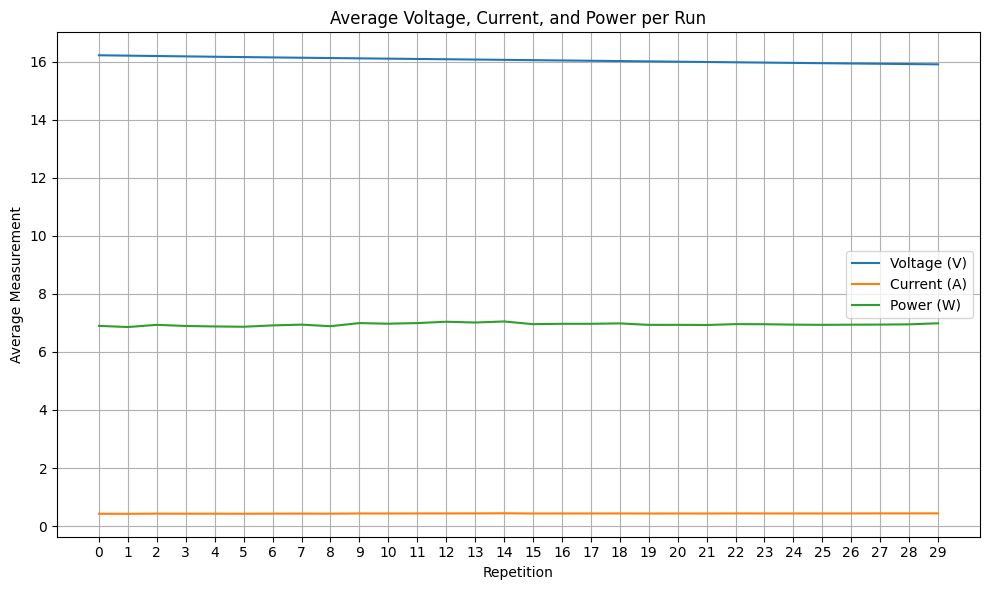

In [23]:
plt.figure(figsize=(10, 6))

plt.plot(avg_per_run["repetition"], avg_per_run["voltage"], label="Voltage (V)")
plt.plot(avg_per_run["repetition"], avg_per_run["current"], label="Current (A)")
plt.plot(avg_per_run["repetition"], avg_per_run["power"], label="Power (W)")

plt.title("Average Voltage, Current, and Power per Run")
plt.xlabel("Repetition")
plt.ylabel("Average Measurement")
plt.xticks(avg_per_run["repetition"])  # Show all run numbers
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


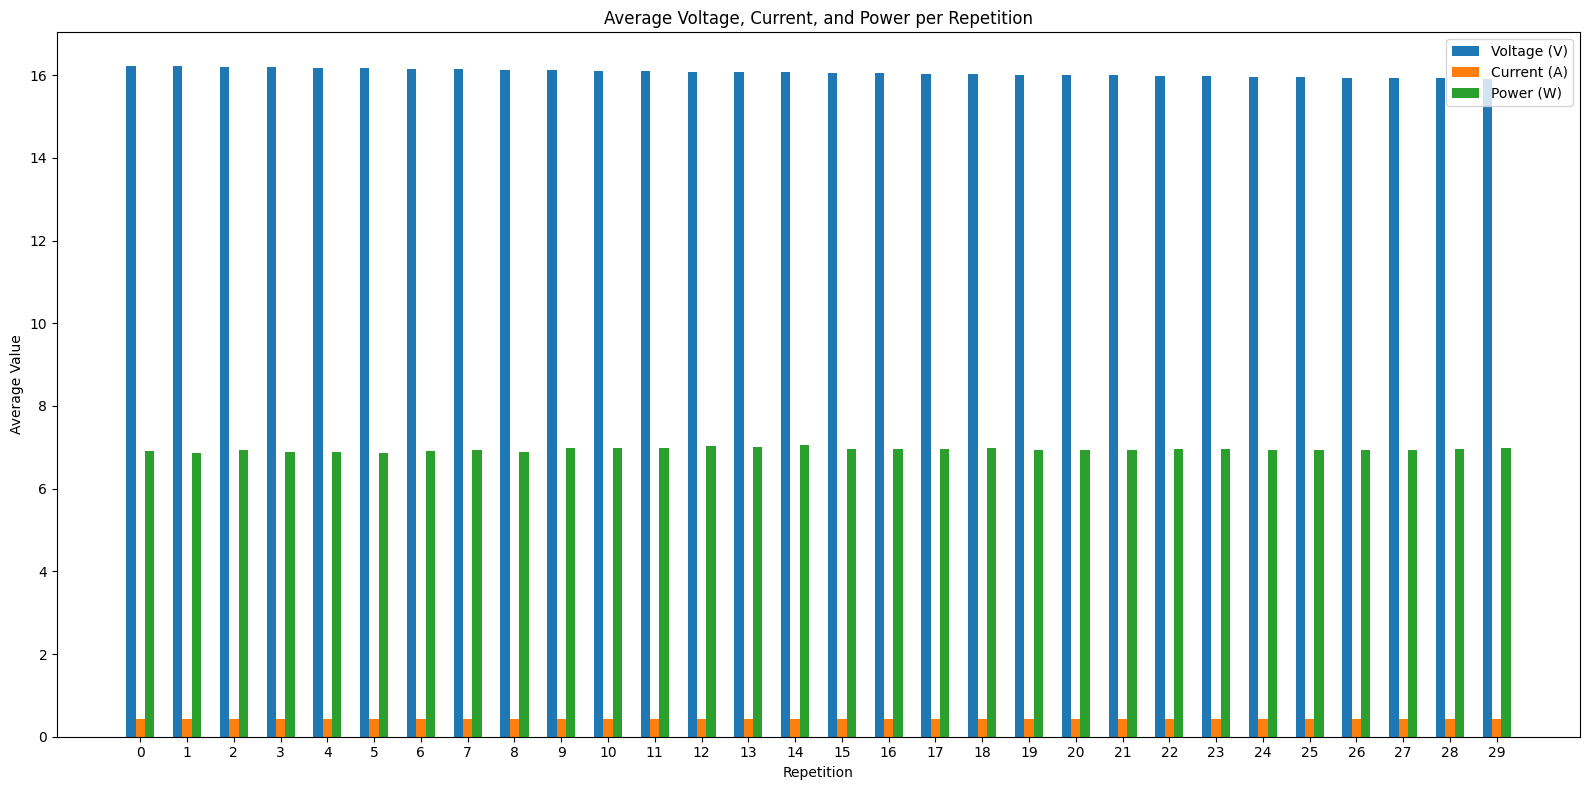

In [24]:
# 2. Create X locations
reps = avg_per_run["repetition"].values
space = 3
x = np.arange(len(reps)) * space  # positions on x-axis

# 3. Set bar width
width = 0.6

# 4. Plot bars for each metric
plt.figure(figsize=(16, 8))
plt.bar(x - width, avg_per_run["voltage"], width, label="Voltage (V)", color="tab:blue")
plt.bar(x,         avg_per_run["current"], width, label="Current (A)", color="tab:orange")
plt.bar(x + width, avg_per_run["power"],   width, label="Power (W)",   color="tab:green")

# 5. Add labels and formatting
plt.xlabel("Repetition")
plt.ylabel("Average Value")
plt.title("Average Voltage, Current, and Power per Repetition")
plt.xticks(x, reps)
plt.legend()
# plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

## Average per experiment
Now, I take the average of the entire repetitions and compute only one value per variable. Average voltage, current and power

In [20]:
overall_avg = df[["voltage", "current", "power"]].mean()
display(overall_avg)


voltage    16.061876
current     0.431888
power       6.947625
dtype: float64